## Import libraries

In [1]:
!unzip /content/doi_10.5061_dryad.gt413__v1.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install nilearn


[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import nilearn as nil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from nilearn import image
from nilearn import masking
#from nilearn.plotting import image
from pathlib import Path

/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read in fmri data

doi_10.5061_dryad.gt413__v1 is the name of the folder of all data taken from: https://datadryad.org/stash/dataset/doi:10.5061/dryad.gt413

This folder contains a description of the data files included as well as .mat files for subjects 1-8, readme files for each subject, and a story feature .mat file.


**For our purposes we are only interested on the subject_X.mat files.**

In [2]:
fMRI_folder = Path('../doi_10.5061_dryad.gt413__v1')
#fMRI_folder = Path('/content')
assert fMRI_folder.exists(), f"Folder: {fMRI_folder} does not exist."

mat_files = sorted(list(fMRI_folder.glob('subject_*.mat')))

## Build 4d matrix
The subject_X.mat files contain matrices in the size of [ number of voxels X 1351 TRs ] and a mapping of the 3D coordinates of each voxel.
The below function maps each voxel in the 2D matrix to its corresponding location to form the 4D brain volumes.

In [3]:
# Builds a matrix of shape (x,y,z,nTRs) for a subject
#
# Params:
# x_dim: maximum x coord
# y_dim: maximum y coord
# z_dim: maximum z coord
# nTRs: number of total fmri scans
# data: fmri data of shape (nTRs, nVoxels)
# colToCoord: maps each voxel in data to its 3d coordinates
#
# Returns: matrix of shape (x,y,z,nTRs) with each voxel having its BOLD data

def build_4d_matrix(file,x_dim,y_dim,z_dim,nTRs,data,colToCoord):
    indices = get_run_indices(file)
    full = [x for y in indices for x in y]
    d2 = []
    for a in range(len(indices)):
        if a == 3:
            part = signal.detrend(data[indices[a][0]:])
        else:
            part = np.array(signal.detrend(data[indices[a][0]:indices[a][-1]+1]))
        d2.append(part)
    
    data2 = np.array([y for x in range(len(d2)) for y in d2[x]])
    matrix = np.zeros((x_dim,y_dim,z_dim,len(data2)))
    row_count = 0
    for voxel_id in range(data2.shape[1]):
        x,y,z = colToCoord[voxel_id]
        matrix[x-1, y-1, z-1, :] = data2[:,voxel_id]
    return matrix


In [4]:
def get_run_indices(file):
    l = []
    l2 = []
    mat_contents = sio.loadmat(file)
    for x in range(len(mat_contents['words'][0])):
        if mat_contents['words'][0][x][2] > 0.5:
            l.append((mat_contents['words'][0][x][1][0][0]//2)+4)
    for x in range(len(l)):
        if x == 0:
            l2.append(list(set([y for y in range(l[0]) if y not in [a for a in range(10)]])))
        else:
            l2.append(list(set([y for y in range(l[x-1]+10,l[x])])))

    return l2


For each subject_X.mat file, the 4D brain volumes will be contructed and a .nii image will be created.

dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 37913)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 33740)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 29307)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 26851)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 27073)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 34837)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 30689)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 31047)


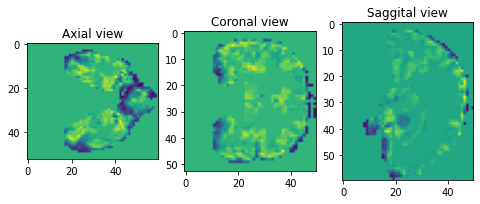

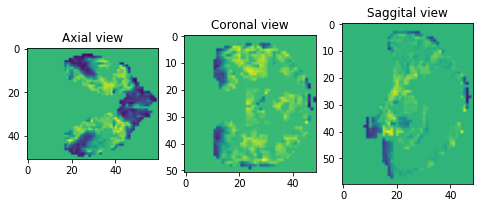

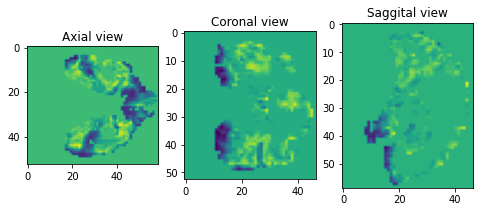

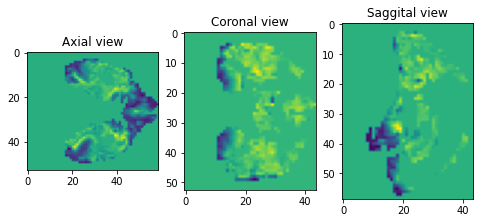

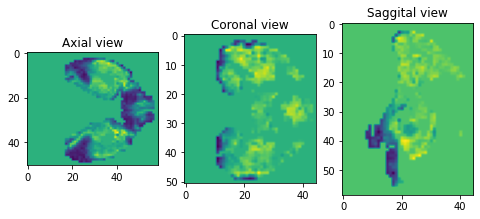

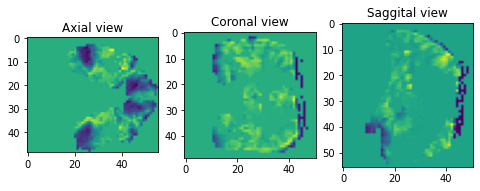

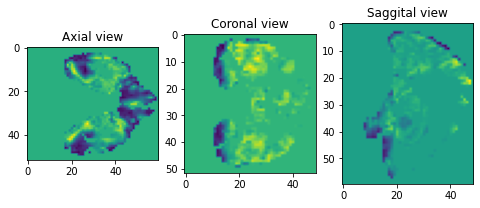

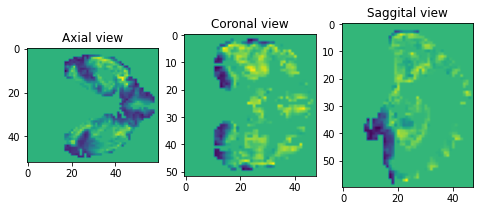

In [5]:
affine_4d = np.eye(4,4)

subjects_4d = []
count= 0
for f in mat_files:
    mat_contents = sio.loadmat(f)
    print(mat_contents.keys())
    #print(type(mat_contents['data']))
    print(mat_contents['data'].shape)
    #print('({x}, {y}, {z})'.format(x=mat_contents['meta']['dimx'][0][0][0][0], y=mat_contents['meta']['dimy'][0][0][0][0], z=mat_contents['meta']['dimz'][0][0][0][0]))
    #print(get_run_indices(f))
    n_TRs = mat_contents['data'].shape[0]
    #
    data_4d = build_4d_matrix(f,mat_contents['meta']['dimx'][0][0][0][0], mat_contents['meta']['dimy'][0][0][0][0], mat_contents['meta']['dimz'][0][0][0][0], n_TRs, mat_contents['data'], mat_contents['meta']['colToCoord'][0][0])
    subjects_4d.append(data_4d)

    img_nii_4d = nib.Nifti1Image(data_4d[:,:,:,:], affine_4d)
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(img_nii_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(img_nii_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(img_nii_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Smoothing

In [6]:
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import signal

For each TR the voxels were treated as a 3D image and smoothed with a gaussian filter (sigma=fwhm / (sqrt(8 * log(2)) * voxelsize, fwhm=6).

Smoothing subject 0 ...
Smoothing subject 1 ...
Smoothing subject 2 ...
Smoothing subject 3 ...
Smoothing subject 4 ...
Smoothing subject 5 ...
Smoothing subject 6 ...
Smoothing subject 7 ...


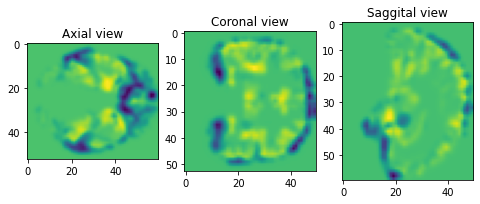

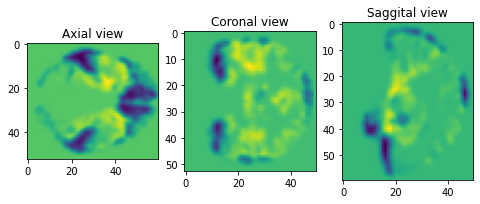

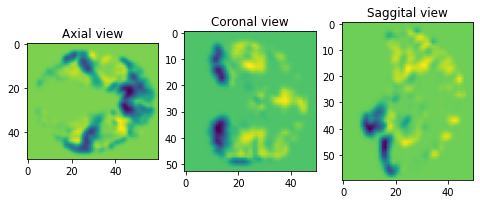

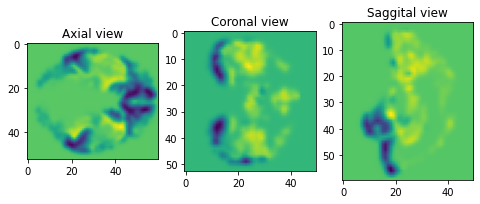

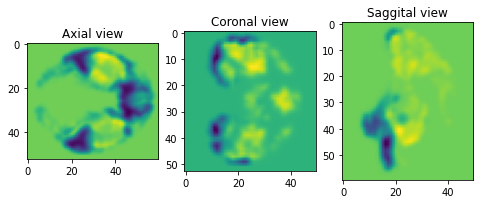

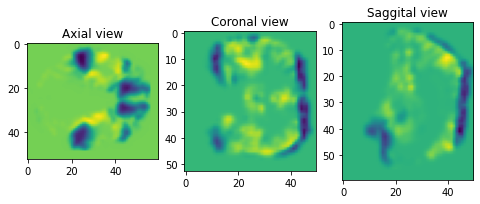

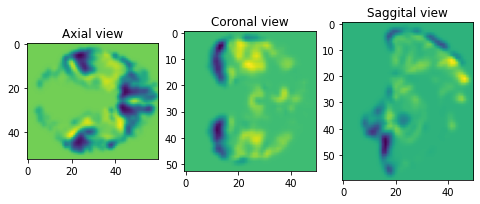

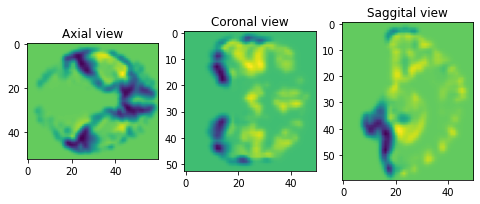

In [7]:
# Taken from https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/spatial_preprocessing.html
affine_4d = np.eye(4,4)
subj_0_img = None

for subj_id, subj_4d in enumerate(subjects_4d):
    print("Smoothing subject", subj_id, "...")
    fwhm = 6
    voxelsize = 3
    data_4d_smoothed = np.zeros(subj_4d.shape)

    for x in range(subj_4d.shape[3]):
        vol = subj_4d[:, :, :, x]
        sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
        smoothed_vol = gaussian_filter(vol, sigma=sigma)
        data_4d_smoothed[:,:,:,x] = smoothed_vol

    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    smooth_img_nii_4d = nib.Nifti1Image(data_4d_smoothed[:,:,:,:], affine_4d)
    #make all images the same size
    if subj_id == 0:
        subj_0_img = smooth_img_nii_4d
    else:
        smooth_img_nii_4d = nil.image.resample_to_img(smooth_img_nii_4d, subj_0_img)
    
    nib.save(smooth_img_nii_4d, fMRI_folder / smooth_file_name)

    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(smooth_img_nii_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(smooth_img_nii_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(smooth_img_nii_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');